In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers, Input
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adadelta

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


reference : https://towardsdatascience.com/quora-question-pairs-detecting-text-similarity-using-siamese-networks-a370f039731b

In [2]:
dirname = '/kaggle/input/quora-question-pairs/'
filename = 'train.csv.zip'

df = pd.read_csv(os.path.join(dirname, filename))
print(df.info())
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None



,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
print('ratio of duplicates:', round(df['is_duplicate'].mean()*100, 2))

qids = pd.Series(df['qid1'].to_list() + df['qid2'].to_list())
print('total # of questions:', len(np.unique(qids)))
print('# of questions appearing multiple times:', np.sum(qids.value_counts() > 1))

ratio of duplicates: 36.92
total # of questions: 537933
# of questions appearing multiple times: 111780


In [ ]:
sample = pd.read_csv(os.path.join(dirname, 'sample_submission.csv.zip'))
sample.head()

In [3]:
# check baseline

dirname = '/kaggle/input/quora-question-pairs/'
test_filename = 'test.csv'
df_test = pd.read_csv(os.path.join(dirname, test_filename))
# p = df['is_duplicate'].mean()
# baseline = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
# baseline.to_csv('submission.csv', index=False)
# baseline.head()

Score: 0.55525

## Train data preprocessing

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def no_abbv(phrase):
    pharse = phrase.lower()
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s'", " ", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"e-mail", " email", phrase)
    phrase = re.sub(r" e.g. ", "  eg ", phrase)
    phrase = re.sub(r" u.s. ", "  american ", phrase)
    phrase = re.sub(r"imrovement", "improvement", phrase)
    
    phrase = re.sub(r"[^A-Za-z0-9]+", " ", phrase)
    
    return phrase.strip()


def remove_stopwords(phrase):
    words = word_tokenize(phrase)
    sent = ' '.join(str(j) for j in words if (j not in stop_words) and (len(j) != 1))
    return sent

def preprocess_text(phrase):
    phrase = no_abbv(phrase)
    return remove_stopwords(phrase)

In [65]:
df_test.isna().sum()

test_id      0
question1    2
question2    4
dtype: int64

In [67]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   test_id    int64 
 1   question1  object
 2   question2  object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [66]:
df_test.loc[df_test['question1'].isna()]

,test_id,question1,question2
1046690,1046690,NaN,How I what can learn android app development?
1461432,1461432,NaN,How distinct can learn android app development?


In [7]:
df.loc[df['question2'].isna()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [5]:
%%time
df = df.dropna()
df_test = df_test.fillna('')

df[['question1', 'question2']] = df[['question1', 'question2']].astype('string')
df_test[['question1', 'question2']] = df_test[['question1', 'question2']].astype('string')

df['q1_re'] = df['question1'].apply(preprocess_text)
df['q2_re'] = df['question2'].apply(preprocess_text)
df_test['q1_re'] = df_test['question1'].apply(preprocess_text)
df_test['q2_re'] = df_test['question2'].apply(preprocess_text)

CPU times: user 15min 53s, sys: 2.03 s, total: 15min 55s
Wall time: 16min 5s


In [8]:
df.shape, df[['q1_re', 'q2_re']].drop_duplicates().shape

((404287, 8), (395197, 2))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[['q1_re', 'q2_re']], df['is_duplicate'], 
                                                test_size=0.2, random_state=24)
X_test = df_test[['q1_re', 'q2_re']]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(323429, 2)
(323429,)
(80858, 2)
(80858,)
(2345796, 2)


# Tokenize & Vectorize

In [7]:
qs = list(X_train['q1_re'].values) + list(X_train['q2_re'].values)

max_words = 10000
tok = Tokenizer(num_words=max_words, oov_token="<OOV>")

tok.fit_on_texts(qs)

train_q1 = tok.texts_to_sequences(X_train['q1_re'].values)
train_q2 = tok.texts_to_sequences(X_train['q2_re'].values)
val_q1 = tok.texts_to_sequences(X_val['q1_re'].values)
val_q2 = tok.texts_to_sequences(X_val['q2_re'].values)
test_q1 = tok.texts_to_sequences(X_test['q1_re'].values)
test_q2 = tok.texts_to_sequences(X_test['q2_re'].values)

<AxesSubplot:ylabel='Density'>

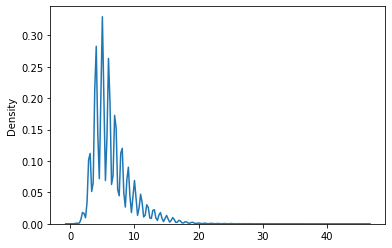

In [13]:
sns.kdeplot([len(x) for x in train_q1])

<AxesSubplot:ylabel='Density'>

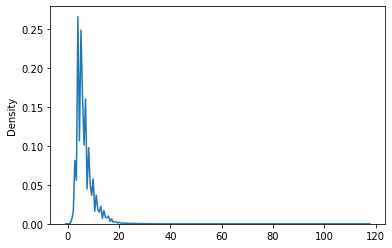

In [14]:
sns.kdeplot([len(x) for x in train_q2])

In [8]:
max_len = 40

train_q1_seq = pad_sequences(train_q1, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2, maxlen=max_len, padding='post')

# Embedding

In [9]:
glove_dir = '/kaggle/input/glove6b/'
embeddings_index = {}
word_index = len(tok.word_index) + 1
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print(f'Found {len(embeddings_index)} word vectors.')
print(word_index)

Found 400000 word vectors.
77559


In [10]:
vec_size = len(embeddings_index['no'])
embedding_vector = None

word_not_in_glove = set()
embedding_matrix = np.zeros((word_index, vec_size))
for word, i in tok.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        word_not_in_glove.add(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(vec_size)

In [11]:
len(word_not_in_glove)

20922

In [22]:
word_not_in_glove

{'hypnotizable',
 'nh2oh',
 'danaerys',
 'lineardiscriminantanalysis',
 'jobmagic',
 'saggi',
 'lemoa',
 'vindu',
 'worldventures',
 'thymines',
 'bbcn',
 'note7',
 'pgdpm',
 'scjp',
 '19500',
 'feltsomethingfrom',
 'desocialization',
 '0xc000014c',
 'stdole32',
 '2178',
 'hinduphobic',
 'ecocentric',
 'lakshdeep',
 'installallation',
 'tomake',
 'startapp',
 'unscribe',
 '7371922543',
 '200n',
 'pgdbf',
 '22lf460a',
 'shinchan',
 'dsquare',
 'oreimo',
 'dldo',
 'opition',
 'fullname',
 'unforgetable',
 'biomeical',
 'schr',
 'zipcall',
 'irumugan',
 'odoo',
 'textnow',
 'algos',
 'smona',
 '1280x720',
 'marhaba',
 'aimit',
 'thankzzz',
 'chossing',
 'shifuji',
 'antihumanism',
 'jirachi',
 'qlikview',
 '85w',
 'winland',
 'mastrubration',
 '9437',
 '135k',
 'hyderbad',
 'wunderlist',
 'kedarkantha',
 'eurofins',
 '4days',
 '7ghz',
 'rocketmail',
 'howmany',
 'nowyoutube',
 'chocos',
 'vorden',
 'patym',
 'sgpt',
 'qubole',
 'posibility',
 'lost12',
 'sitaraman',
 '200gm',
 'proove',
 

# Modeling

In [29]:
n_hidden = 50

input1 = Input(shape=(max_len,), dtype='int32')
input2 = Input(shape=(max_len,), dtype='int32')

shared_model = Sequential()
shared_model.add(layers.Embedding(name='Embedding', input_dim=word_index, 
                                  output_dim=vec_size, weights=[embedding_matrix], 
                                  input_length=max_len, trainable=False))
shared_model.add(layers.LSTM(n_hidden, activation='relu', name='LSTM'))

l1_norm = lambda x: K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
merged = layers.Lambda(function=l1_norm, output_shape=lambda x: x[0], 
                       name='L1_distance')([shared_model(input1), shared_model(input2)])
# pred = layers.Dense(1, activation='sigmoid', name='Similarity_layer')(merged)

model = tf.keras.Model(inputs=[input1, input2], outputs=[merged])
# model = tf.keras.Model(inputs=[input1, input2], outputs=[pred])
# optimizer = Adadelta()

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 50)           7786100     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
L1_distance (Lambda)            (None, 1)            0           sequential_2[0][0]         

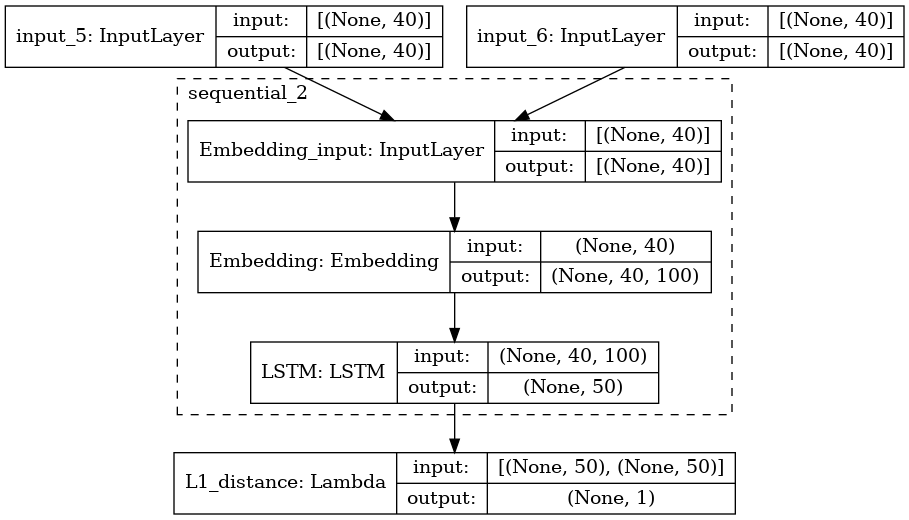

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, expand_nested=True)

In [31]:
from time import time

batch_size = 1024
n_epoch = 5

training_start_time = time()
trained = model.fit([train_q1_seq, train_q2_seq], y_train.values.reshape(-1, 1), 
                    batch_size=batch_size, epochs=n_epoch, 
                    validation_data=([val_q1_seq, val_q2_seq], y_val.values.reshape(-1, 1)))

training_end_time = time()
print(f'Training time finished. {n_epoch} epochs in {training_end_time - training_start_time}')

Epoch 1/5
316/316 [==============================] - 45s 136ms/step - loss: 0.2651 - accuracy: 0.6408 - val_loss: 0.2019 - val_accuracy: 0.7003
Epoch 2/5
316/316 [==============================] - 43s 136ms/step - loss: 0.1926 - accuracy: 0.7179 - val_loss: 0.1845 - val_accuracy: 0.7338
Epoch 3/5
316/316 [==============================] - 43s 137ms/step - loss: 0.1791 - accuracy: 0.7430 - val_loss: 0.1766 - val_accuracy: 0.7480
Epoch 4/5
316/316 [==============================] - 43s 135ms/step - loss: 0.1717 - accuracy: 0.7562 - val_loss: 0.1722 - val_accuracy: 0.7546
Epoch 5/5
316/316 [==============================] - 43s 136ms/step - loss: 0.1665 - accuracy: 0.7659 - val_loss: 0.1695 - val_accuracy: 0.7595
Training time finished. 5 epochs in 263.65877509117126


# Visualization

In [52]:
model.save('/kaggle/working/SiameseLSTM.h5')

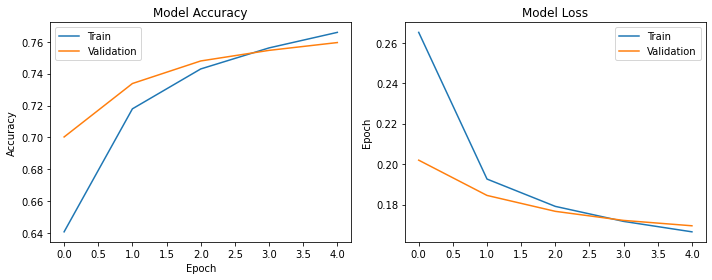

In [43]:
plt.subplots(figsize=(10, 4))

plt.subplot(121)
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(122)
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout(h_pad=1.0)

In [27]:
df_test.loc[0, 'question1'], df_test.loc[0, 'question2']

('How does the Surface Pro himself 4 compare with iPad Pro?',
 'Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?')

In [35]:
model.predict([test_q1_seq[0:2], test_q2_seq[0:2]])

array([[0.52433103],
       [0.4208474 ]], dtype=float32)

In [36]:
prediction = model.predict([test_q1_seq, test_q2_seq])

In [38]:
submission = pd.DataFrame()
submission['test_id'] = df_test['test_id']
submission['is_duplicate'] = prediction
submission.to_csv('submission.csv', index=False)